# Embeddings  Clustering

Embeddings model: BERT

Category: types of news categories

#### Setup

In [77]:
#!pip install wordcloud Levenshtein

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_distances
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sea
import warnings
import Levenshtein as lev

warnings.filterwarnings("ignore")
pd.options.display.max_rows = 999
pd.set_option('max_colwidth', 1000)
SEED=42
notebook_start_time = time.time()

### Data Acces

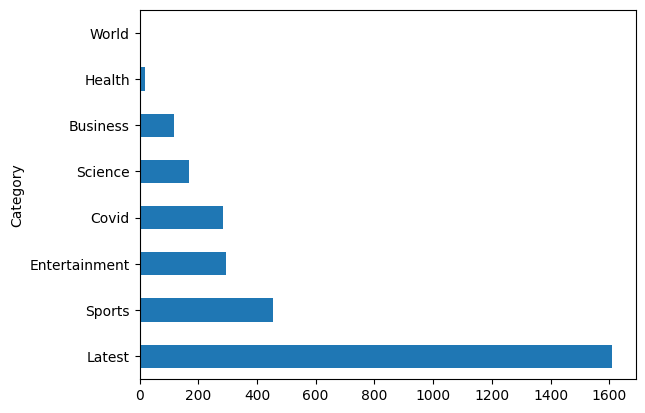

In [91]:
# processed data from Embeddings/hugging_face_bert.ipynb
dataframe = pd.read_parquet('../Datasets/pre_processed_dataframes/embeddings_df.parquet')
dataframe = dataframe[dataframe['language_name'] == 'English'].copy()
ax = dataframe['Category'].value_counts().plot(kind='barh')

In [92]:
valid_categories = ['Entertainment']
dataframe = dataframe[dataframe['Category'].isin(valid_categories)].copy()
len(dataframe)

296

#### TSNE

In [93]:
unique_categories = dataframe['Category'].unique()
category_colors = []
if len(unique_categories) > 1:
    colors = sea.color_palette('hsv', len(unique_categories))
    color_dict = dict(zip(unique_categories, colors))
    category_colors = dataframe['Category'].map(color_dict)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Tempo total de execução = 0.008833333333333334 (minutos)


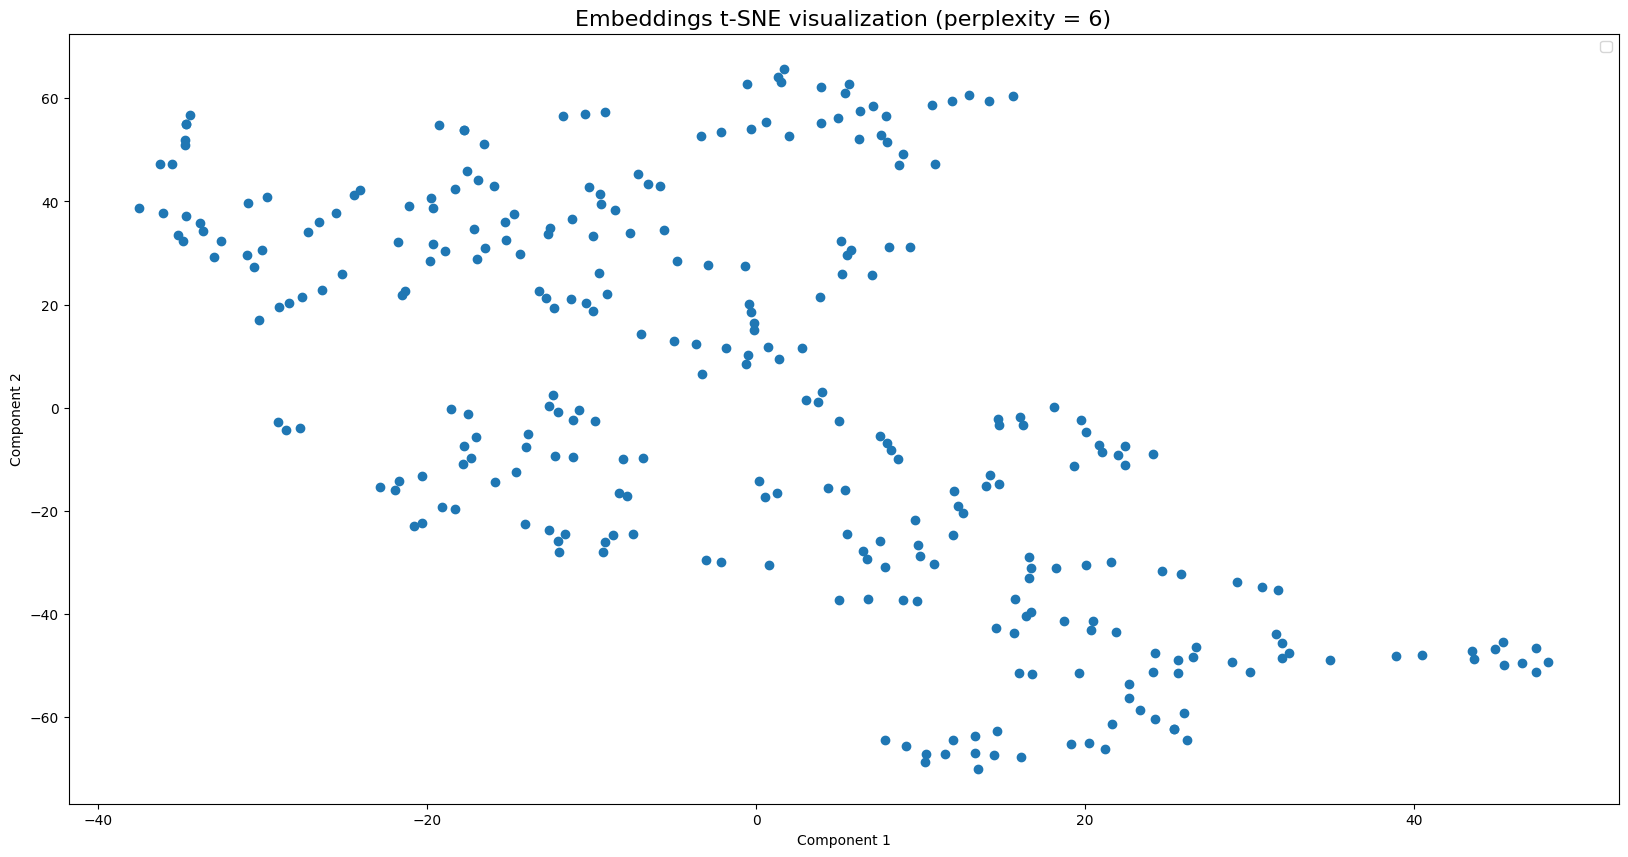

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Tempo total de execução = 0.007333333333333333 (minutos)


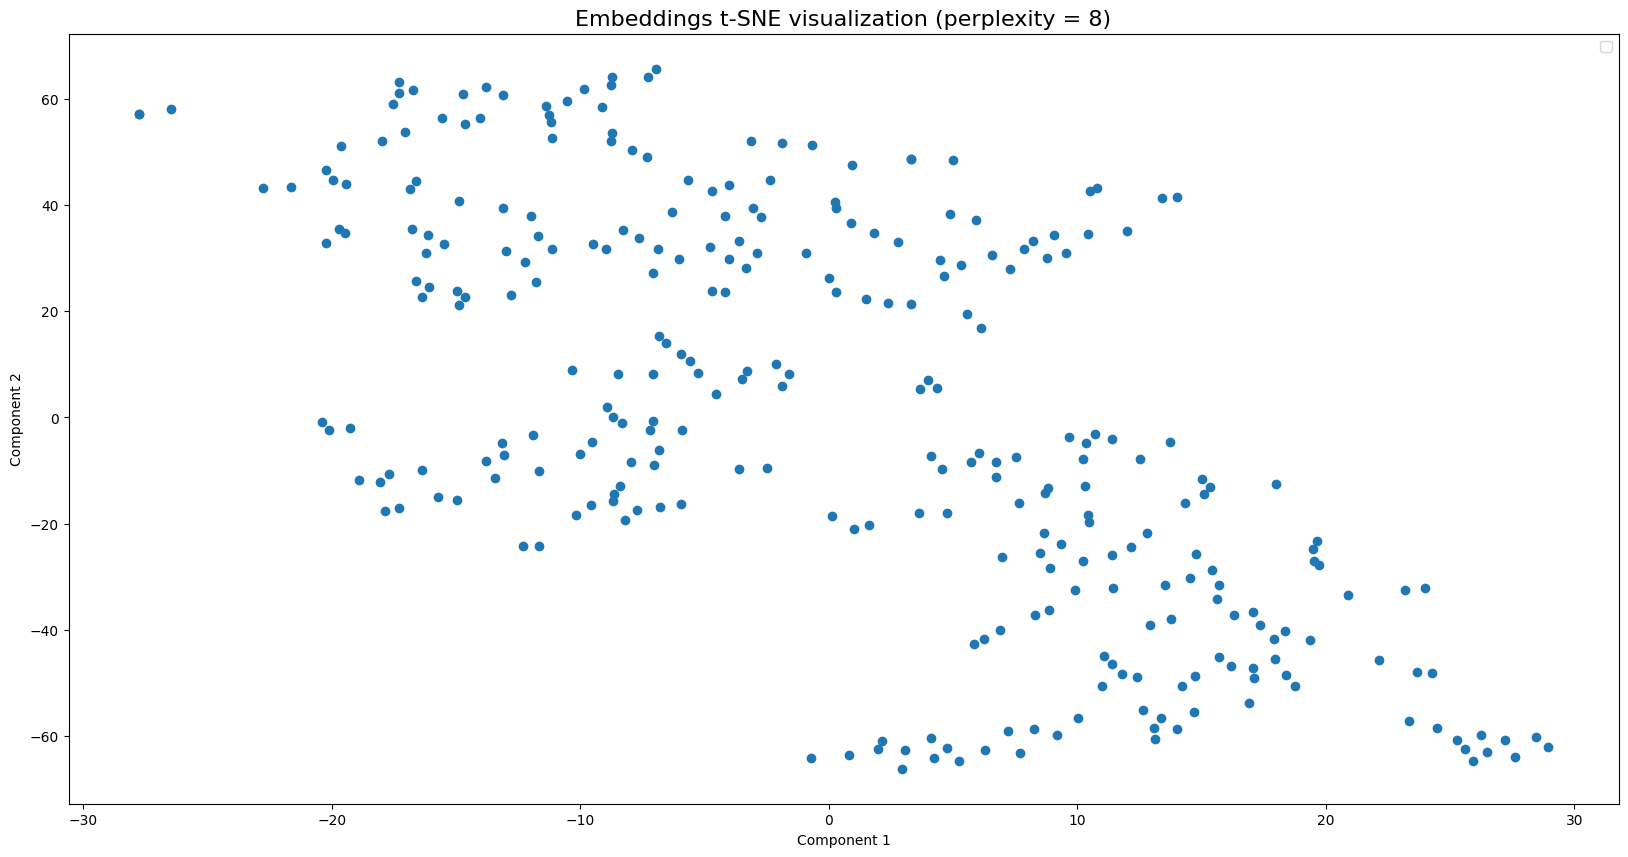

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Tempo total de execução = 0.007500000000000001 (minutos)


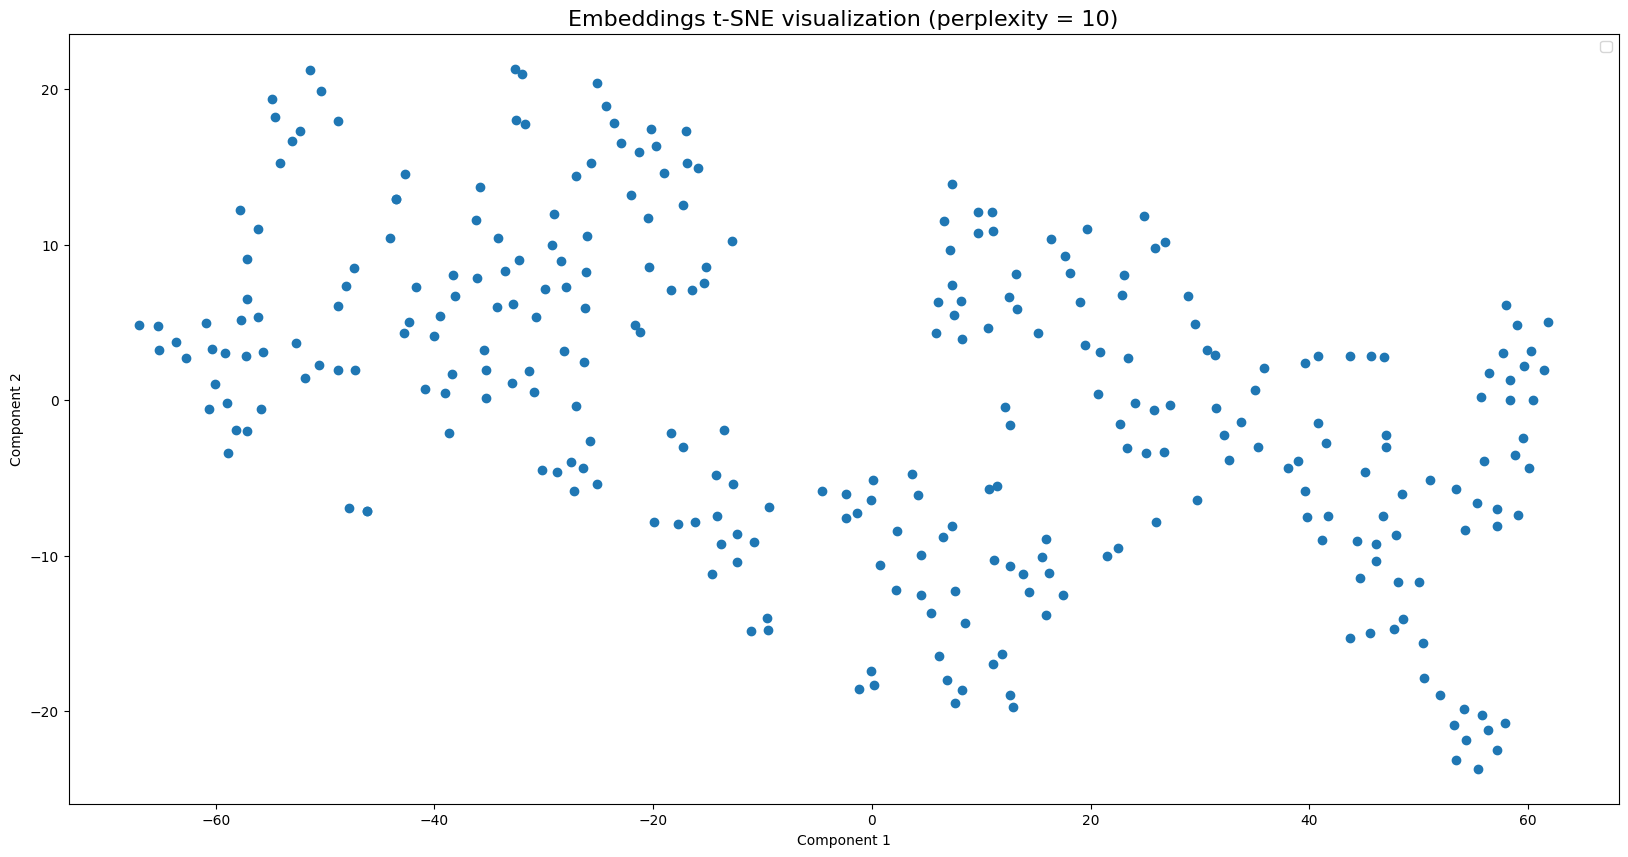

In [94]:
X = np.vstack(dataframe['embeddings_full_description'].values)

for perplexity in np.arange(6, 12, step=2):
    start_time = time.time()
    tsne = TSNE(n_components=2, 
                random_state=42, 
                metric='cosine',            
                verbose=False,                                
                perplexity=perplexity)

    X_tsne = tsne.fit_transform(X)

    end_time = time.time()
    tsne_elapsed_time = np.round(end_time - start_time, 2)/60
    print(f'Tempo total de execução = {tsne_elapsed_time} (minutos)')

    fig = plt.figure(figsize=(20, 10))
    if len(category_colors) > 0:
        ax = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=category_colors)
    else:
        ax = plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
    ax = plt.legend()
    ax = plt.xlabel('Component 1')
    ax = plt.ylabel('Component 2')
    ax = plt.title(f'Embeddings t-SNE visualization (perplexity = {perplexity})', fontsize=16)
    plt.show()    

In [95]:
p=10
tsne = TSNE(n_components=2, 
            random_state=42, 
            metric='cosine',            
            verbose=False,                                 
            perplexity=p)

X_tsne = tsne.fit_transform(X)

### KMeans

#### Select Best Custer Value

For n_clusters = 3 The average silhouette_score is : 0.32407084
For n_clusters = 4 The average silhouette_score is : 0.2304005
For n_clusters = 5 The average silhouette_score is : 0.16482714
For n_clusters = 6 The average silhouette_score is : 0.12458473
For n_clusters = 7 The average silhouette_score is : 0.11217576
For n_clusters = 8 The average silhouette_score is : 0.09676881
For n_clusters = 9 The average silhouette_score is : 0.09506356


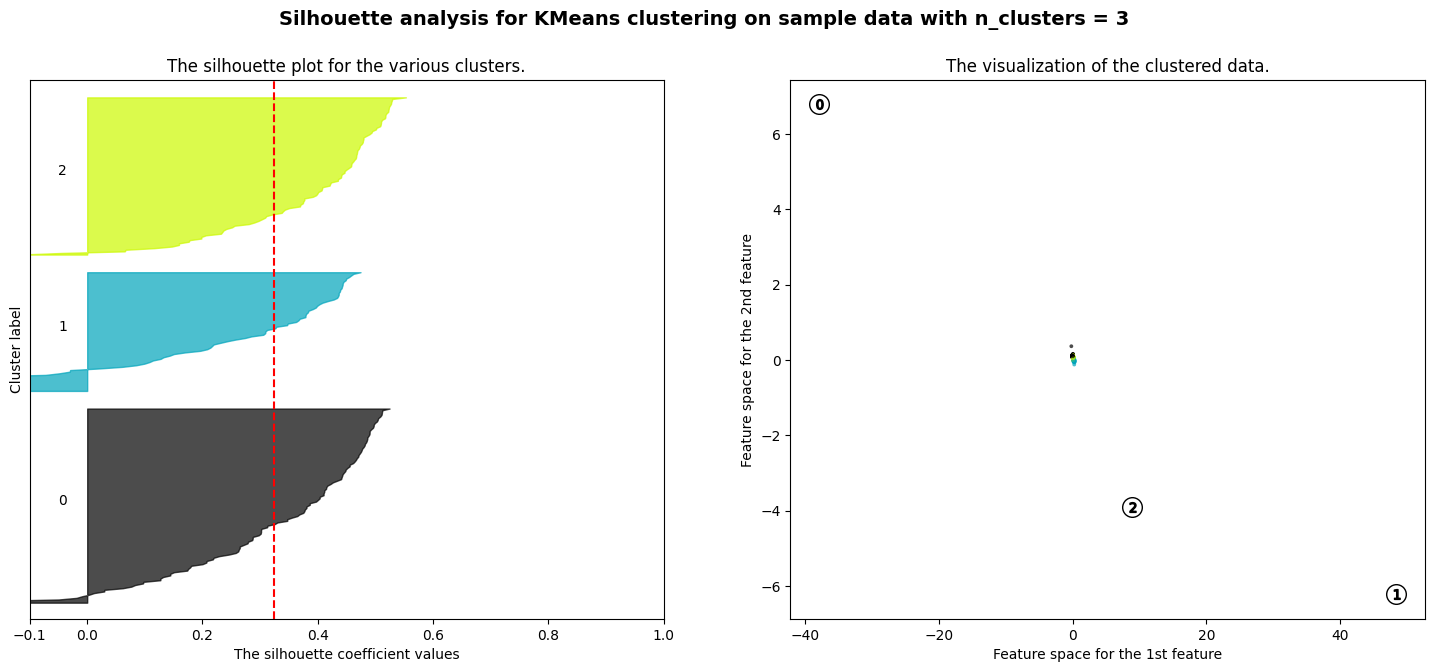

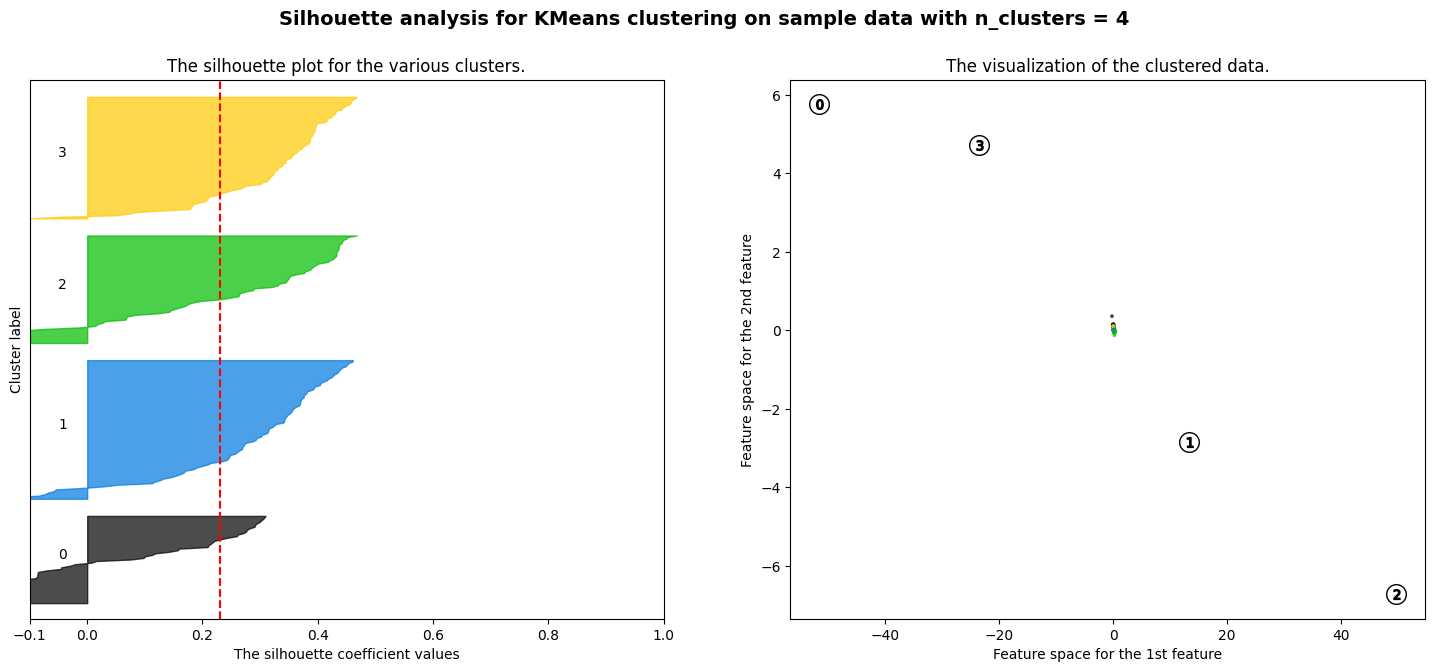

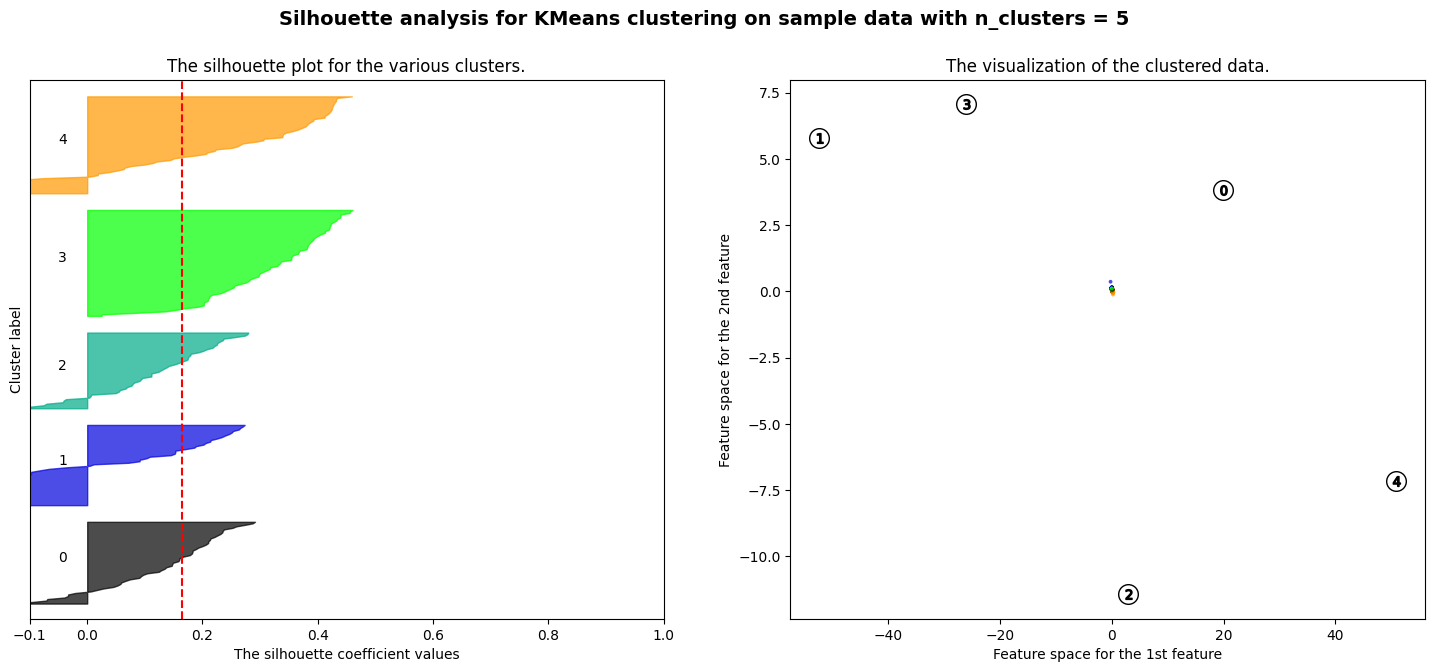

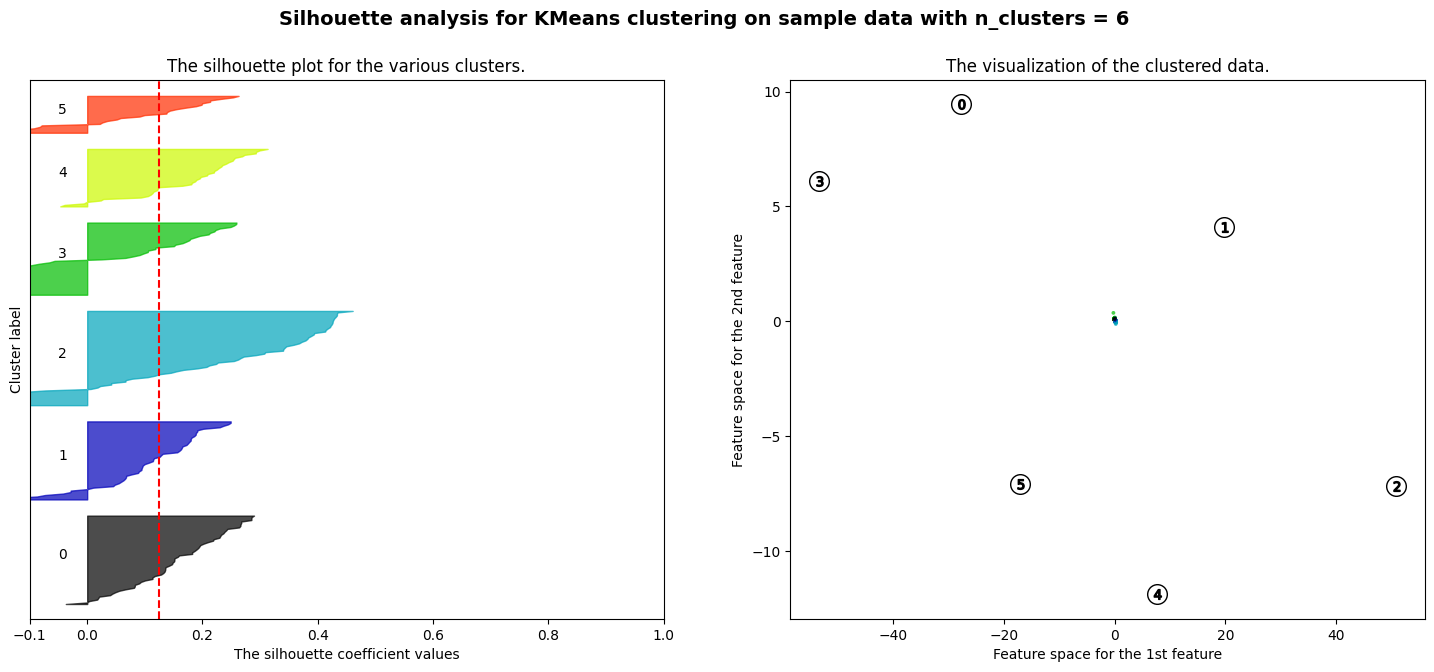

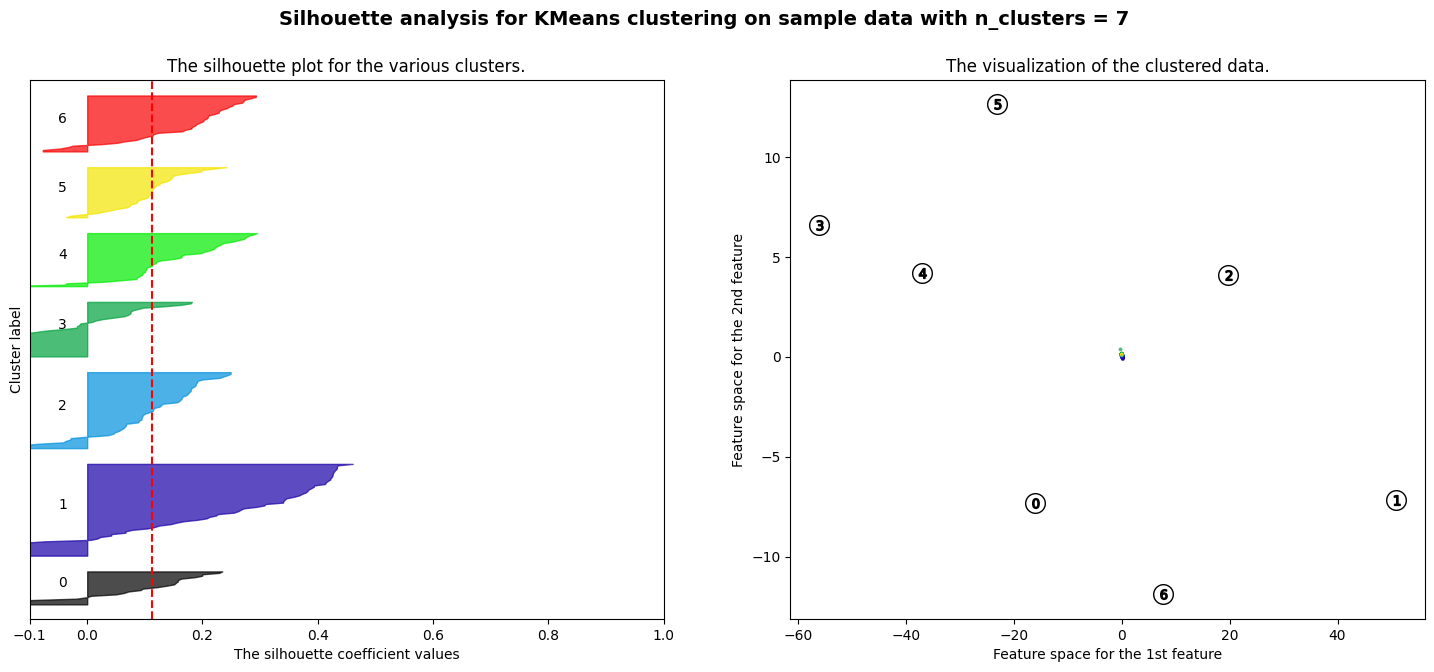

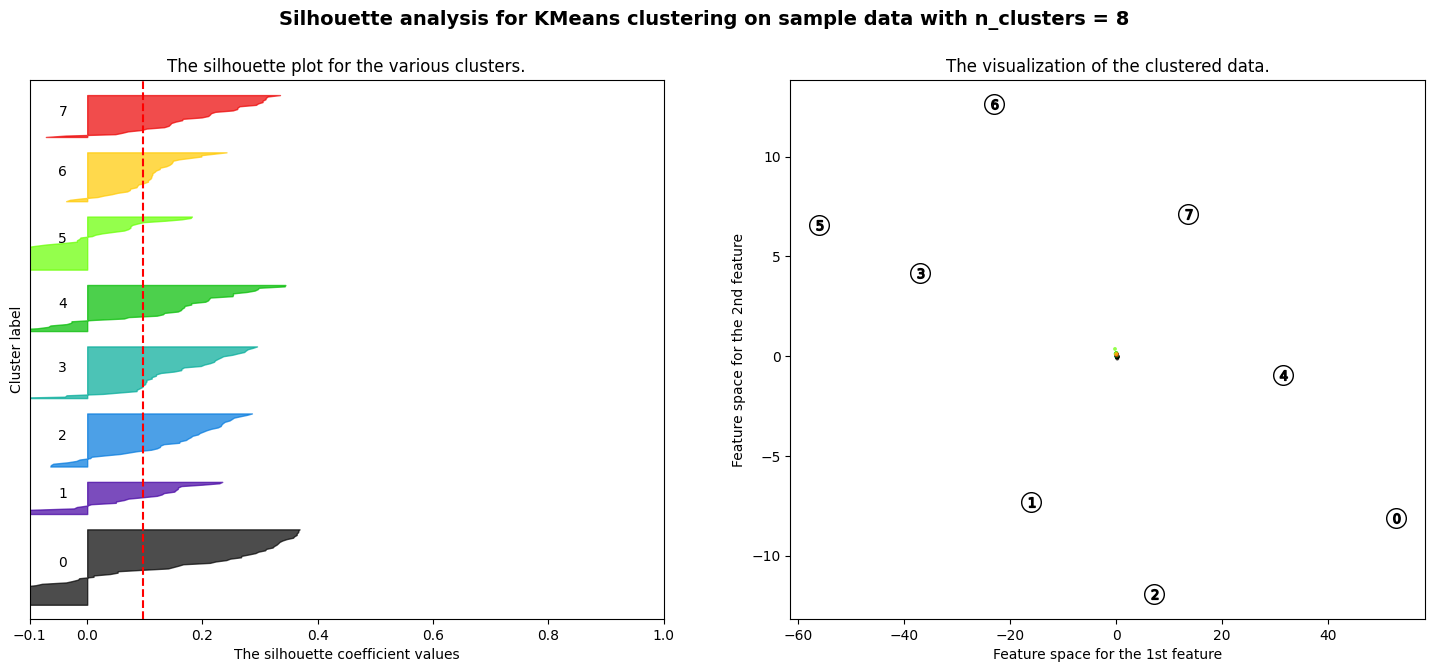

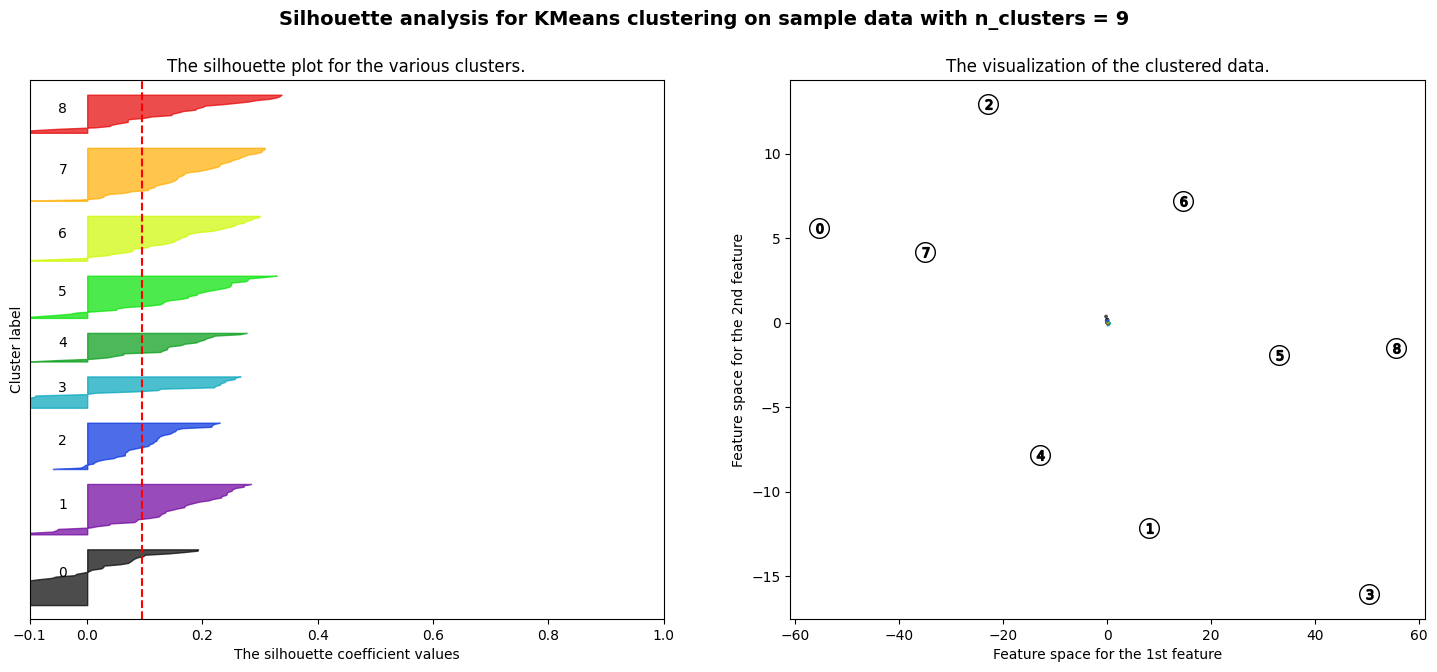

In [96]:
range_n_clusters = 10
best_cluster_score = {}
for n_clusters in np.arange(3, range_n_clusters):    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])    
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42, max_iter=500)
    cluster_labels = clusterer.fit_predict(X_tsne)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    best_cluster_score[n_clusters] = silhouette_avg
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

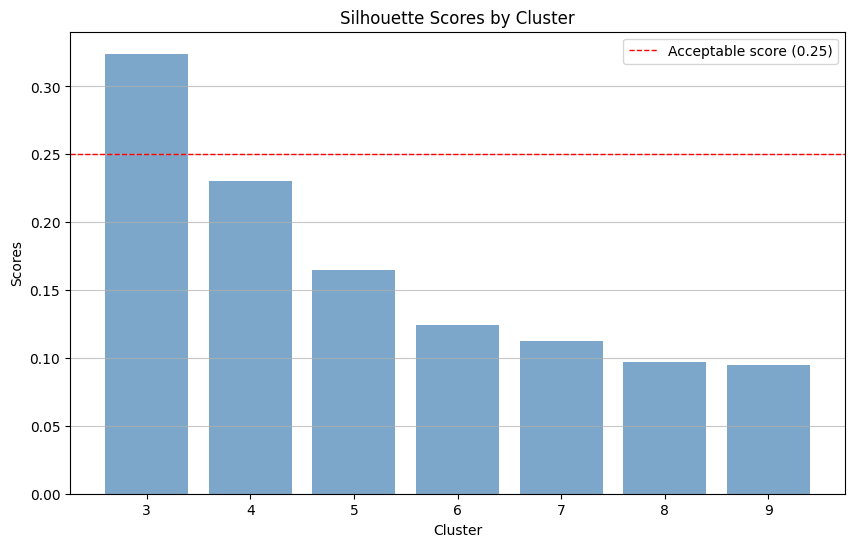

In [97]:
keys = list(best_cluster_score.keys())
values = list(best_cluster_score.values())
plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='steelblue', alpha=0.7)
plt.axhline(y=0.25, color='red', linestyle='--', linewidth=1, label='Acceptable score (0.25)')
plt.title('Silhouette Scores by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Scores')
plt.xticks(keys)
plt.legend()
plt.grid(axis='y', alpha=0.7)
plt.show()

In [98]:
best_cluster = max(best_cluster_score, key=best_cluster_score.get)
best_cluster

3

#### Training KMeans using best cluster

In [99]:
labels = KMeans(n_clusters=best_cluster, random_state=42).fit_predict(X_tsne)

#### Silhouette Scores por Sample

In [100]:
silhouette_scores = silhouette_samples(X_tsne, labels)

In [101]:
silhouette_scores_list = []
for i in range(len(X_tsne)):
    silhouette_scores_list.append(silhouette_scores[i])

In [102]:
for i in range(len(X_tsne)):
    if silhouette_scores[i] > 0.7:
        print(f"Amostra {i}: Score de Silhueta = {silhouette_scores[i]}")

Amostra 3: Score de Silhueta = 0.7010921835899353
Amostra 8: Score de Silhueta = 0.7005384564399719
Amostra 10: Score de Silhueta = 0.7214155793190002
Amostra 11: Score de Silhueta = 0.723500669002533
Amostra 25: Score de Silhueta = 0.710439920425415
Amostra 32: Score de Silhueta = 0.7107546925544739
Amostra 45: Score de Silhueta = 0.7318182587623596
Amostra 97: Score de Silhueta = 0.7113651037216187
Amostra 140: Score de Silhueta = 0.7048349380493164
Amostra 146: Score de Silhueta = 0.7185635566711426
Amostra 147: Score de Silhueta = 0.7035425305366516
Amostra 150: Score de Silhueta = 0.7039967179298401
Amostra 154: Score de Silhueta = 0.731597363948822
Amostra 174: Score de Silhueta = 0.7022572159767151
Amostra 177: Score de Silhueta = 0.703179657459259
Amostra 179: Score de Silhueta = 0.7258924245834351
Amostra 185: Score de Silhueta = 0.7313585877418518
Amostra 190: Score de Silhueta = 0.7234401106834412
Amostra 205: Score de Silhueta = 0.7024198174476624
Amostra 213: Score de Silh

In [103]:
for i in range(len(X_tsne)):
    if silhouette_scores[i] < 0:
        print(f"Amostra {i}: Score de Silhueta = {silhouette_scores[i]}")

Amostra 66: Score de Silhueta = -0.010347497649490833


#### Silhouette Scores by Cluster

In [104]:
cluster_silhouette_scores = {}
for cluster_label in set(labels):    
    examples_in_cluster = silhouette_scores[labels == cluster_label]    
    cluster_score = np.mean(examples_in_cluster)         
    cluster_silhouette_scores[cluster_label] = cluster_score        

In [105]:
dataframe['cluster'] = labels
dataframe['silhouette_sample'] = silhouette_scores_list
dataframe['cluster_silhouette_scores'] = dataframe['cluster'].apply(lambda x: cluster_silhouette_scores[x])

In [106]:
dataframe[['title', 'cluster', 'silhouette_sample', 'cluster_silhouette_scores']].sample(5)

,title,cluster,silhouette_sample,cluster_silhouette_scores
4904,Star Trek: Prodigy Sneak Peeks Debut During NFL Sunday Football,2,0.648928,0.452669
4868,‘Promised Land’ & ‘Mysterious Benedict Society’ Score Tax Credits For Moving To California,2,0.538029,0.452669
5047,Ron's Gone Wrong is Jean-Phillippe Vine's First Time Directing,2,0.629971,0.452669
4796,Marvel Teases New Ghost Rider Series,0,0.386803,0.558773
4972,"Chris Hemsworth Thought Thor's Absence in Civil War Meant He Was ""Written Out"" of the MCU",1,0.704204,0.601561


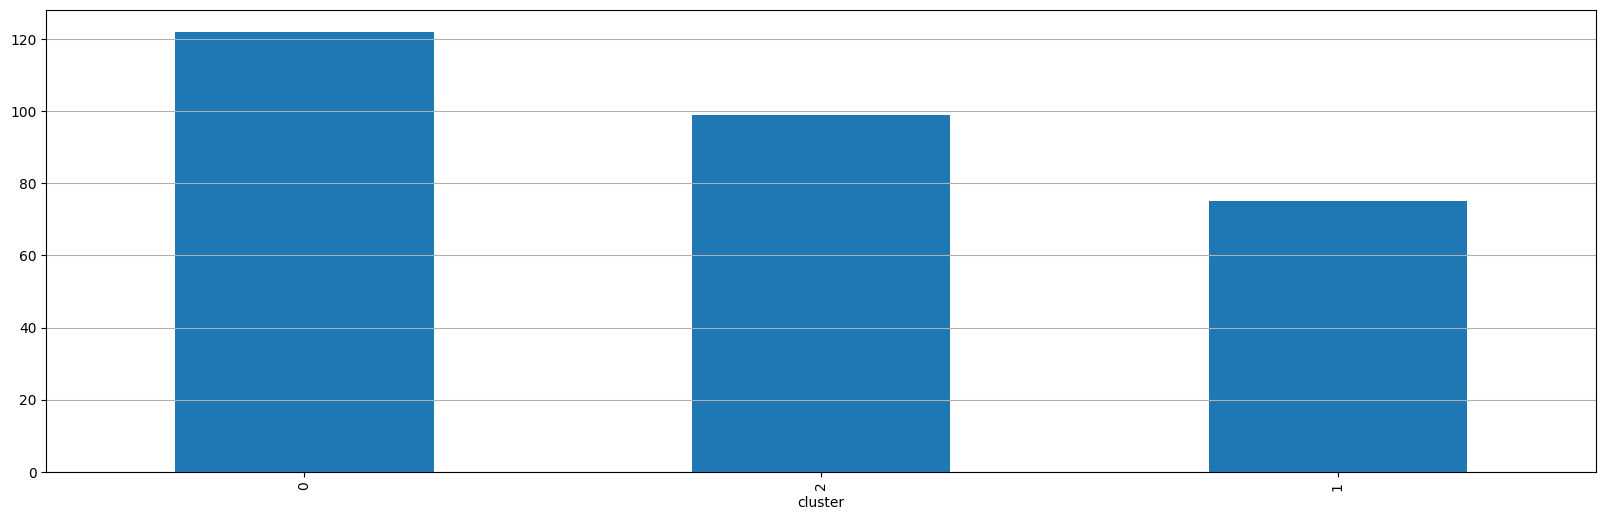

In [107]:
dataframe['cluster'].value_counts().plot(kind='bar', figsize=(20, 6))
ax = plt.grid(axis='y')

### Main texts in clusters

In [108]:
import tqdm
from collections import Counter

def most_common_word(text, max_words=10):
    counter = Counter(text.split(' '))
    counter = list(counter.keys())[0:max_words]
    counter= [c for c in counter if len(c) > 1]
    return counter   


def plot_word_cloud(df, text_column):
    cluster_text = df[text_column].values
    cluster_text = " ".join(cluster_text)
    cluster_text = [word for word in cluster_text.split(' ') if len(word) > 1]    
    cluster_text = " ".join(cluster_text)
    cluster_text = Counter(cluster_text.split(' '))
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(cluster_text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


Cluster =  0


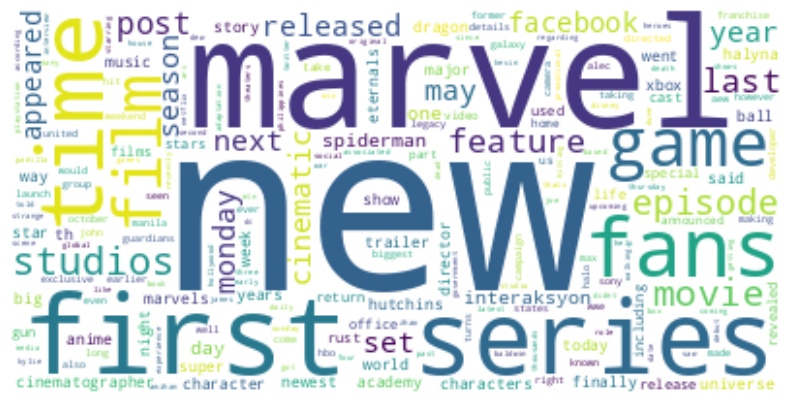

Cluster =  1


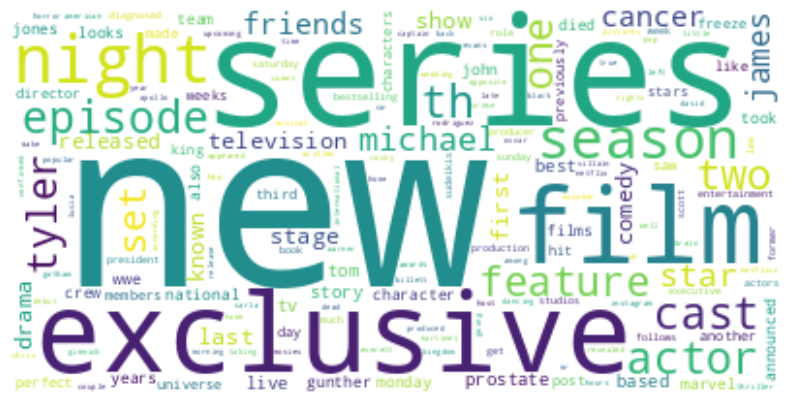

Cluster =  2


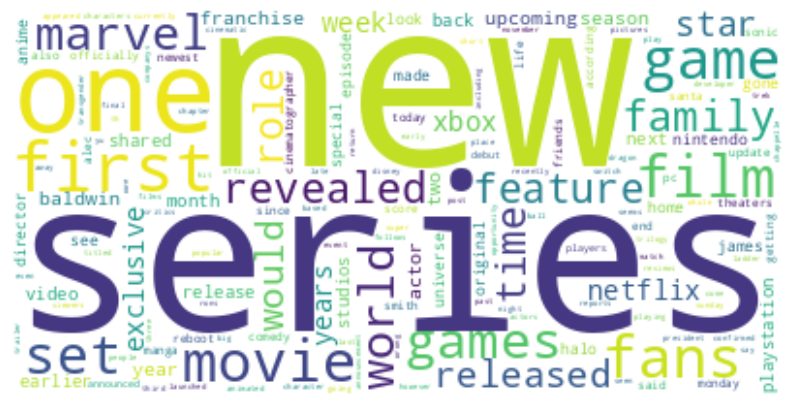

In [109]:
for cluster in np.unique(labels):
    print('Cluster = ', cluster)
    df_filtered = dataframe[(dataframe['cluster'] == cluster) & (dataframe['silhouette_sample'] > 0)].copy()
    plot_word_cloud(df_filtered, 'cleaned_description')

### Similar texts between clusters

In [110]:
cluster = 0
cluster_df = dataframe[dataframe['cluster'] == cluster].copy()
cluster_df = cluster_df.reset_index(drop=True)

In [115]:
idx_1 = 20
idx_2 = 12

desc_1 = cluster_df.loc[idx_1, 'cleaned_description']
desc_2 = cluster_df.loc[idx_2, 'cleaned_description']

print(desc_1[0:1000])
print('\n')
print(desc_2[0:1000])

ratio = lev.ratio(desc_1, desc_2)
print('\n')
print("Similaridade leveinstein entre as descrições =  ", np.around(ratio, 3))
print('\n')

vices hit documentary series dark side ring air season finale coming thursday covering united states v mcmahon court case better known steroid trials clip features interviews likes dave meltzer jim ross wwe attorney jerry mcdevitt wwe blumhouse television


kylie padillas fans made word amihan trend twitter cheer time state weather bureau announced onset northeast monsoon amihan season country amihan name padillas character reboot gmas encantadia fantasy series first post pagasas announcement support kylie padilla make amihan trend twitter ph appeared first interaksyon


Similaridade leveinstein entre as descrições =   0.409


